# DS project

## Data preperation

Imports

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC

Reading the data from csv files

In [2]:
patients = pd.read_csv("Data/trainData/patients.csv")
conditions = pd.read_csv("Data/trainData/conditions.csv")
careplans = pd.read_csv("Data/trainData/careplans.csv")
medications = pd.read_csv("Data/trainData/medications.csv")
procedures = pd.read_csv("Data/trainData/procedures.csv")

merged = pd.merge(conditions, patients, left_on="Patient_id", right_on="Id")
merged.drop(["Patient_id"], inplace=True, axis=1)

Dummifying the procedures file dataframe

In [3]:
# Create binary columns indicating whether each patient received a specific procedure
procedures_received = pd.get_dummies(procedures["Procedure"], prefix="Received").groupby(procedures["Patient_id"]).max()

# Reset the index for a clean output
procedures_received.reset_index(inplace=True)

Filtering out the rows where diagnosis was "Suspected lung cancer"

In [4]:
lung = merged[merged["Diagnosis"] == "Suspected lung cancer (situation)"]

Finding the difference between first treatment and diagnosis of cancer

In [5]:
lung["Start"] = pd.to_datetime(lung["Start"], format="%d/%m/%Y")
careplans_date = pd.merge(lung[["Start", "Id"]], careplans, left_on="Id", right_on="Patient_id")
careplans_date = careplans_date[careplans_date["Reason"].isin(["Primary small cell malignant neoplasm of lung  TNM stage 1 (disorder)", "Non-small cell carcinoma of lung  TNM stage 1 (disorder)"])]
careplans_date["CarePlan_Start"] = pd.to_datetime(careplans_date["CarePlan_Start"], format="%d/%m/%Y")
careplans_date["date_difference"] = careplans_date["CarePlan_Start"] - careplans_date["Start"]
careplans_date["date_difference"] = careplans_date["date_difference"].dt.days

C:\Users\opuusalu\AppData\Local\Temp\ipykernel_2004\1509393743.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lung["Start"] = pd.to_datetime(lung["Start"], format="%d/%m/%Y")


Finding the amount of lung cancer treatments recieved in the first year after lung cancer.

In [6]:
# Merge medications with lung DataFrame to associate medications with diagnosis dates
merged_data = pd.merge(medications, lung, left_on="Patient_id", right_on="Id")

# Convert the "Start" and "Diagnosis" columns to datetime
merged_data["Start"] = pd.to_datetime(merged_data["Start_x"], format="%Y-%m-%dT%H:%M:%SZ")
merged_data["Diagnosis"] = pd.to_datetime(merged_data["Start_y"], format="%d/%m/%Y")

# Filter the DataFrame based on the specified conditions
filtered_medications = merged_data[
    ((merged_data["Reason"] == "Non-small cell carcinoma of lung  TNM stage 1 (disorder)") |
    (merged_data["Reason"] == "Primary small cell malignant neoplasm of lung  TNM stage 1 (disorder)")) &
    (merged_data["Start"] >= merged_data["Diagnosis"]) &  # Only include medications after diagnosis
    (merged_data["Start"] <= merged_data["Diagnosis"] + pd.DateOffset(days=365))  # Only include medications in the first year
]

# Count the unique medications for each patient
treatment_counts = filtered_medications.groupby("Id").size().reset_index(name="Treatment_Count")

Filtering the rows where diagnosis was less than 5 years ago since we can not know if those people lived or died 5 years after cancer which we need for train dataset.

In [7]:
# Convert "Start" column to datetime format
lung["Start"] = pd.to_datetime(lung["Start"], format="%d/%m/%Y")

# Calculate the date 5 years ago
five_years_ago = datetime.now() - timedelta(days=5*365)

# Drop rows where "Start" date is less than 5 years ago
lung = lung[lung["Start"] < five_years_ago]

C:\Users\opuusalu\AppData\Local\Temp\ipykernel_2004\1920745262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lung["Start"] = pd.to_datetime(lung["Start"], format="%d/%m/%Y")


If DeathDate is missing it is set to today's date for training purposes.

In [8]:
# Convert "Start" and "DeathDate" columns to datetime format
lung["Start"] = pd.to_datetime(lung["Start"], format="%d/%m/%Y")
lung["DeathDate"] = pd.to_datetime(lung["DeathDate"], format="%d/%m/%Y", errors='coerce')

# Calculate today's date
today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)

# Set missing "DeathDate" values to today
lung.loc[lung["DeathDate"].isna(), "DeathDate"] = today


Creating row 'y' in dataset which contains 1 if patient lived 5 years after diagnosis and 0 if not.

In [9]:
# Convert "Start" and "DeathDate" columns to datetime format
lung["Start"] = pd.to_datetime(lung["Start"], format="%d/%m/%Y")
lung["DeathDate"] = pd.to_datetime(lung["DeathDate"], format="%d/%m/%Y", errors='coerce')

# Calculate the date difference
lung["date_difference"] = lung["DeathDate"] - lung["Start"]

# Set missing "DeathDate" values to today
today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
lung.loc[merged["DeathDate"].isna(), "DeathDate"] = today

# Create a new column "y" based on the condition
lung["y"] = (lung["date_difference"] > timedelta(days=1825)).astype(int)


Dropping irrelevant columns

In [10]:
columns_to_drop = ["date_difference", "BirthDate", "DeathDate"]

# Drop the specified columns
lung.drop(columns=columns_to_drop, inplace=True, errors='ignore')

Aggregating different values in diagnosis column into table that contains diagnosis as column head and then True and False values for each patient

In [11]:
encoded = pd.get_dummies(conditions, columns=["Diagnosis"])

columns = encoded.columns[4:]
aggregated = encoded.groupby("Patient_id").agg({**{col: 'max' for col in columns}})

Merging all data together

In [12]:
merged = pd.merge(aggregated, lung[["Id", "y", "Gender"]], left_on="Patient_id", right_on="Id")
merged["Gender"] = merged["Gender"] == "F"
merged = pd.merge(merged, treatment_counts[["Id","Treatment_Count"]], left_on="Id", right_on="Id")
merged = pd.merge(merged, procedures_received, left_on="Id", right_on="Patient_id")
merged = pd.merge(merged, careplans_date[["Id", "date_difference"]], on="Id")

This part conludes the data preperation. We're left with DataFrame merged in the end.

## Training the models on data

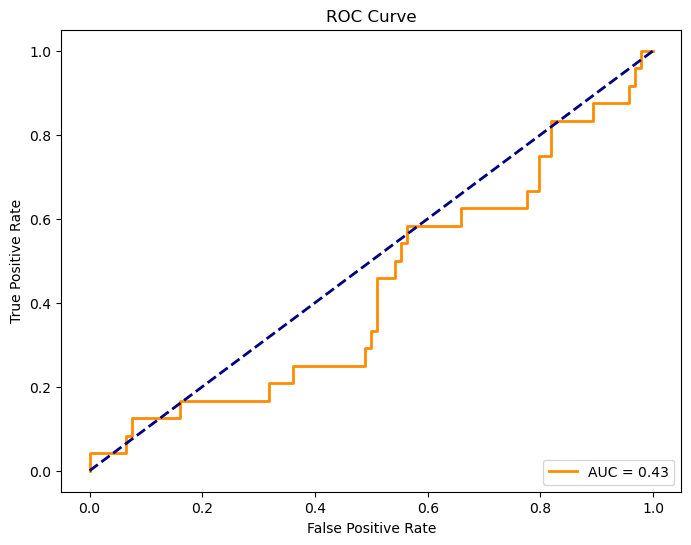

AUC: 0.43


In [13]:
# Drop unnecessary columns
X = merged.drop(columns=["y", "Id", "Patient_id"])
y = merged["y"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use PCA to reduce dimensionality to 30 components
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Create a model (e.g., RandomForestClassifier) and train it on the reduced data
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred_proba = model.predict_proba(X_test_pca)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f'AUC: {roc_auc:.2f}')


C:\Users\opuusalu\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


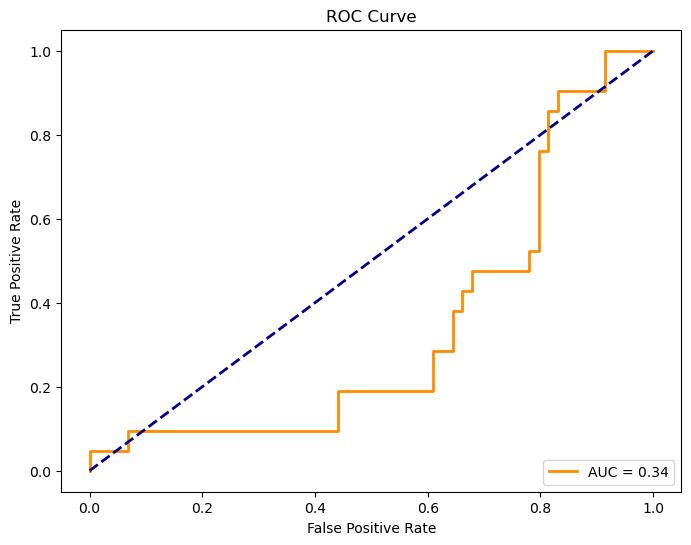

AUC: 0.34


In [14]:
# Drop unnecessary columns
X = merged.drop(columns=["y", "Id", "Patient_id"])
y = merged["y"]

# Use RandomUnderSampler to downsample the majority class
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train a model (e.g., Logistic Regression)
model = LogisticRegression(max_iter=1000, solver='sag')  # or 'liblinear', 'saga', etc.
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f'AUC: {roc_auc:.2f}')


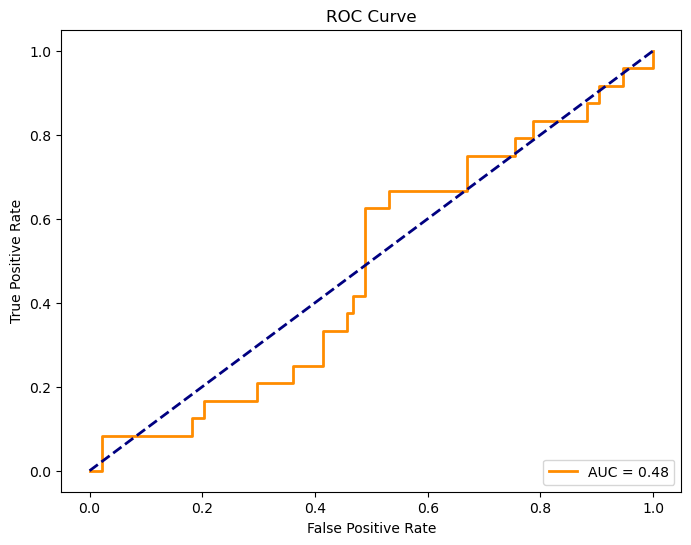

AUC: 0.48


In [15]:
# Drop unnecessary columns
X = merged.drop(columns=["y", "Id", "Patient_id"])
y = merged["y"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Support Vector Machine (SVM) classifier and train it on the data
model = SVC(probability=True, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f'AUC: {roc_auc:.2f}')


In [16]:
# Drop unnecessary columns
X = merged.drop(columns=["y", "Id", "Patient_id"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a model (e.g., RandomForestClassifier) and train it on the full data
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 100 features
top_features = feature_importance_df.head(10)['Feature'].tolist()

# Keep only the top features in the dataset
X_top_features = X[top_features]

# Now X_top_features contains only the top 100 features
X_top_features

,date_difference,Treatment_Count,Received_Injection of tetanus antitoxin,Received_Depression screening using Patient Health Questionnaire Nine Item score (procedure),Received_Partial resection of colon,Received_Fine needle aspiration biopsy of lung (procedure),Received_Human epidermal growth factor receptor 2 gene detection by fluorescence in situ hybridization (procedure),Diagnosis_Received higher education (finding),Received_Ultrasonography of bilateral breasts (procedure),Diagnosis_Laceration - injury (disorder)
0,16,122,False,False,False,False,False,True,False,False
1,14,124,False,False,False,False,False,True,False,False
2,11,122,False,True,False,False,False,True,False,False
3,29,96,False,True,False,False,False,False,False,False
4,11,136,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...
584,68,92,False,False,False,False,False,False,False,False
585,8,126,False,True,False,False,False,False,False,False
586,45,102,False,True,False,False,False,True,False,False
587,28,94,False,True,True,False,False,False,False,False


This is the end of the notebook.